In [ ]:
import imageio
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from IPython.display import Image

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
K.clear_session()

def cnn_model(img, cb_img):
    
    conv_1 = Conv2D(16, (7, 7), activation='relu', padding='same', strides=1)(img)
    conv_1 = Conv2D(32, (5, 5), activation='relu', padding='same', strides=1)(conv_1)
    conv_1 = Conv2D(64, (3, 3), activation='relu', padding='same', strides=1)(conv_1)
   

    conv_2 = Conv2D(16, (7, 7), activation='relu', padding='same', strides=1)(cb_img)
    conv_2 = Conv2D(32, (5, 5), activation='relu', padding='same', strides=1)(conv_2)
    conv_2 = Conv2D(64, (3, 3), activation='relu', padding='same', strides=1)(conv_2)
   

    add_1 = tf.keras.layers.Add()([conv_1, conv_2])

    conv_4 = Conv2D(16, (3, 3), activation='relu', padding='same', strides=1)(add_1)
    conv_5 = Conv2D(16, (3, 3), activation='relu', padding='same', strides=1)(conv_4)

    conv_6 = Conv2D(3, (3, 3), activation='relu', padding='same', strides=1)(conv_5)
   

    return conv_6


In [ ]:
############################################################################################################# TRAINING PART ################################################################################################

In [ ]:
d_path = '/content/drive/MyDrive/UnderwaterImageEnhancement/dataset/train-set/raw'
cb_d_path = '/content/drive/MyDrive/UnderwaterImageEnhancement/dataset/train-set/cb_raw'
t_path = '/content/drive/MyDrive/UnderwaterImageEnhancement/dataset/train-set/reference'

data = []
cb_data = []
target = []

im_h = 224
im_w = 224
for imagePath in os.listdir(d_path):

    # get full the path of the raw(real), cb_raw(color balancing real) and reference(target) images
    data_path = os.path.join(d_path, imagePath)
    cb_data_path = os.path.join(cb_d_path, imagePath)
    target_path = os.path.join(t_path, imagePath)
    
    #read the images
    img = cv2.imread(data_path)
    cb_img = cv2.imread(cb_data_path)
    target_img = cv2.imread(target_path)

    #resize the images into 224 x 224
    img = cv2.resize(img, (im_h, im_w))
    cb_img = cv2.resize(cb_img, (im_h, im_w))
    target_img = cv2.resize(target_img, (im_h, im_w))
        
    # put the images into array list
    data.append(img)
    cb_data.append(cb_img)
    target.append(target_img)


In [ ]:
# convert arrays into numpy arrays
data = np.array(data)
cb_data = np.array(cb_data)
target = np.array(target)

print(data.shape, cb_data.shape, target.shape)

(712, 224, 224, 3) (712, 224, 224, 3) (712, 224, 224, 3)


In [ ]:
%cd '/content/drive/MyDrive/UnderwaterImageEnhancement/models/npfile-model3/'

# save the numpy arrays
np.save('data', data)
np.save('cb_data', cb_data)
np.save('target', target)

/content/drive/MyDrive/UnderwaterImageEnhancement/models/npfile-model3


In [ ]:
%cd '/content/drive/MyDrive/UnderwaterImageEnhancement/models/npfile-model3/'

# load the numpy arrays
data = np.load('data.npy')
cb_data = np.load('cb_data.npy')
target = np.load('target.npy')

print(data.shape, cb_data.shape, target.shape)

/content/drive/MyDrive/UnderwaterImageEnhancement/models/npfile-model3
(712, 224, 224, 3) (712, 224, 224, 3) (712, 224, 224, 3)


In [ ]:
im_h = 224
im_w = 224

# initiate keras tensor input_sample, input_cb_sample, and output_
input_sample = Input(shape=(im_h, im_w, 3))
input_cb_sample = Input(shape=(im_h, im_w, 3))
output_ = cnn_model(input_sample, input_cb_sample)

# create the model in function way by specfying input and output
model_enhancer = Model(inputs=[input_sample, input_cb_sample], outputs=output_)

# Configures the model for training with loss function and optimizer

#optimizer = tf.keras.optimizers.Adam(lr=0.001)
#model_enhancer.compile(loss='mse', optimizer=optimizer, metrics=['mse', 'accuracy'])
model_enhancer.compile(loss='mse', optimizer='adam', metrics=['mse', 'accuracy'])
model_enhancer.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 224, 224, 16) 2368        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 224, 224, 16) 2368        input_4[0][0]                    
____________________________________________________________________________________________

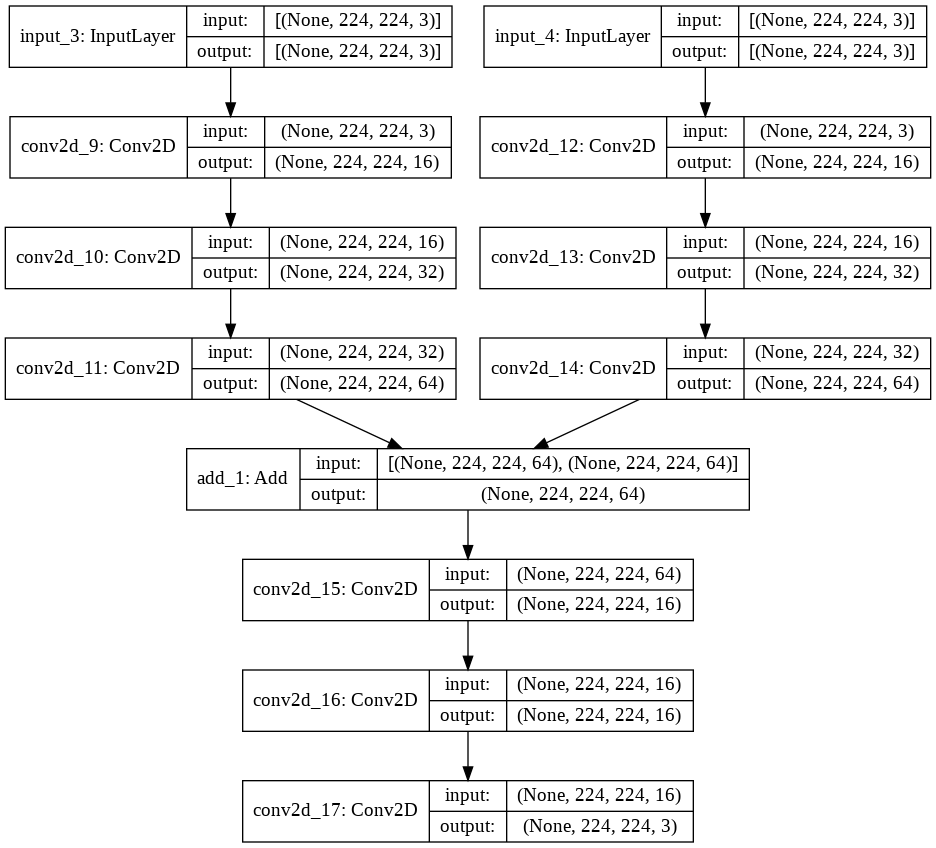

In [ ]:
plot_model(model_enhancer, to_file='/content/drive/MyDrive/UnderwaterImageEnhancement/models/model3_view.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='/content/drive/MyDrive/UnderwaterImageEnhancement/models/model3_view.png')

In [ ]:
# split training dataset into 80% for training and 20% for validation
train_data, val_data, train_cb_data, val_cb_data, train_target, val_target = train_test_split(data,
                                                                                              cb_data,
                                                                                              target,
                                                                                              test_size=0.2)

print(len(train_data), len(train_cb_data), len(train_target), len(val_data), len(val_cb_data), len(val_target))

569 569 569 143 143 143


In [ ]:
epoch = 100

#
# checkpoint = ModelCheckpoint('/content/drive/MyDrive/UnderwaterImageEnhancement/checkpoints/model3/model-{epoch:03d}.h5', monitor="val_loss", save_best_only=False, mode='auto', save_freq=epoch)

# train the model
# history = model_enhancer.fit([train_data, train_cb_data], train_target, validation_data=([val_data, val_cb_data], val_target), batch_size=16, epochs=epoch, callbacks=[checkpoint], shuffle=True)


checkpoint_path = "/content/drive/MyDrive/UnderwaterImageEnhancement/checkpoints/model3/weights_best.hdf5"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss',mode='min', save_best_only=True, verbose=1)

# train the model
history = model_enhancer.fit([train_data, train_cb_data], train_target, validation_data=([val_data, val_cb_data], val_target), batch_size=16, epochs=epoch, callbacks=[cp_callback], shuffle=True)


Epoch 1/100
36/36 [==============================] - 25s 512ms/step - loss: 8202.6963 - mse: 8202.6953 - accuracy: 0.4924 - val_loss: 7162.6611 - val_mse: 7162.6606 - val_accuracy: 0.5210

Epoch 00001: val_loss improved from inf to 7162.66113, saving model to /content/drive/MyDrive/UnderwaterImageEnhancement/checkpoints/model3/weights_best.hdf5
Epoch 2/100


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


36/36 [==============================] - 13s 361ms/step - loss: 7238.2354 - mse: 7238.2349 - accuracy: 0.5030 - val_loss: 7074.7061 - val_mse: 7074.7061 - val_accuracy: 0.5609

Epoch 00002: val_loss improved from 7162.66113 to 7074.70605, saving model to /content/drive/MyDrive/UnderwaterImageEnhancement/checkpoints/model3/weights_best.hdf5
Epoch 3/100
36/36 [==============================] - 13s 362ms/step - loss: 6916.7651 - mse: 6916.7656 - accuracy: 0.6410 - val_loss: 6801.9902 - val_mse: 6801.9907 - val_accuracy: 0.6582

Epoch 00003: val_loss improved from 7074.70605 to 6801.99023, saving model to /content/drive/MyDrive/UnderwaterImageEnhancement/checkpoints/model3/weights_best.hdf5
Epoch 4/100
36/36 [==============================] - 13s 362ms/step - loss: 6046.2998 - mse: 6046.3003 - accuracy: 0.6202 - val_loss: 2044.4026 - val_mse: 2044.4026 - val_accuracy: 0.3099

Epoch 00004: val_loss improved from 6801.99023 to 2044.40259, saving model to /content/drive/MyDrive/UnderwaterImag

In [ ]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'mse', 'accuracy', 'val_loss', 'val_mse', 'val_accuracy'])


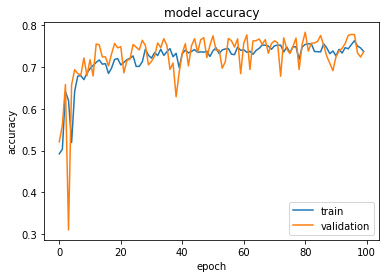

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

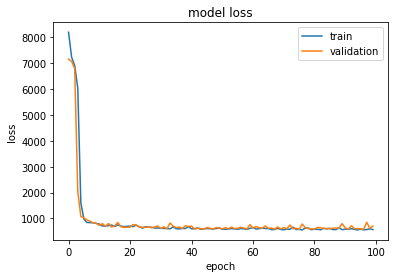

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='validation')
plt.legend()
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
###################################################################################################### TESTING PART ####################################################################################################

In [ ]:
###### How to load and use weights from a checkpoint #########

im_h = 224
im_w = 224

# initiate keras tensor input_sample, input_cb_sample, and output_
input_sample = Input(shape=(im_h, im_w, 3))
input_cb_sample = Input(shape=(im_h, im_w, 3))
output_ = cnn_model(input_sample, input_cb_sample)

# create the model in function way by specfying input and output
model_enhancer_test = Model(inputs=[input_sample, input_cb_sample], outputs=output_)

# load weights
model_enhancer_test.load_weights("/content/drive/MyDrive/UnderwaterImageEnhancement/checkpoints/model3/weights_best.hdf5")

# Configures the model for training with loss function and optimizer
model_enhancer_test.compile(loss='mse', optimizer='adam', metrics=['mse', 'accuracy'])

In [ ]:
############################################################# Evaluate the model in testing part

d_path = '/content/drive/MyDrive/UnderwaterImageEnhancement/dataset/test-set/raw'
cb_d_path = '/content/drive/MyDrive/UnderwaterImageEnhancement/dataset/test-set/cb_raw'
t_path = '/content/drive/MyDrive/UnderwaterImageEnhancement/dataset/test-set/reference'

data = []
cb_data = []
target = []

im_h = 224
im_w = 224
for imagePath in os.listdir(d_path):

    # get full the path of the raw(real), cb_raw(color balancing real) and reference(target) images
    data_path = os.path.join(d_path, imagePath)
    cb_data_path = os.path.join(cb_d_path, imagePath)
    target_path = os.path.join(t_path, imagePath)
    
    #read the images
    img = cv2.imread(data_path)
    cb_img = cv2.imread(cb_data_path)
    target_img = cv2.imread(target_path)

    #resize the images into 224 x 224
    img = cv2.resize(img, (im_h, im_w))
    cb_img = cv2.resize(cb_img, (im_h, im_w))
    target_img = cv2.resize(target_img, (im_h, im_w))
        
    # put the images into array list
    data.append(img)
    cb_data.append(cb_img)
    target.append(target_img)


# convert arrays into numpy arrays
test_data = np.array(data)
test_cb_data = np.array(cb_data)
test_target = np.array(target)

print(test_data.shape, test_cb_data.shape, test_target.shape)

%cd '/content/drive/MyDrive/UnderwaterImageEnhancement/models/npfile-model3/'

# save the numpy arrays
np.save('test_data', test_data)
np.save('test_cb_data', test_cb_data)
np.save('test_target', test_target)

(178, 224, 224, 3) (178, 224, 224, 3) (178, 224, 224, 3)
/content/drive/MyDrive/UnderwaterImageEnhancement/models/npfile-model3


In [ ]:
%cd '/content/drive/MyDrive/UnderwaterImageEnhancement/models/npfile-model3/'

# load the numpy arrays
test_data = np.load('test_data.npy')
test_cb_data = np.load('test_cb_data.npy')
test_target = np.load('test_target.npy')

print(test_data.shape, test_cb_data.shape, test_target.shape)


# estimate accuracy and the MSE on test dataset using loaded weights
scores = model_enhancer_test.evaluate([test_data, test_cb_data ], test_target, verbose=0)

#print("%s: %.2f%%" % (model_enhancer_test.metrics_names[2], scores[2]*100))

/content/drive/MyDrive/UnderwaterImageEnhancement/models/npfile-model3
(178, 224, 224, 3) (178, 224, 224, 3) (178, 224, 224, 3)


In [ ]:
# Testing Accuracy
print("%s: %.2f%%" % (model_enhancer_test.metrics_names[2], scores[2]*100))

accuracy: 70.64%


In [ ]:
# Testing Loss - MSE for test data set
print(scores[1])
print('MSE for testing set: ', format(scores[1], ".4f"))

508.64251708984375
MSE for testing set:  508.6425


In [ ]:
# PSNR for test data set

from math import log10, sqrt

def PSNR():
 mse = scores[1]
 #print(mse)
 if(mse == 0):
  return 100
 max_pixel = 255.0
 psnr = 20 * log10(max_pixel / sqrt(mse))
 return psnr 

value = PSNR()
print(value)

print('PSNR for testing set: ', format(value, ".4f"), "dB")

21.066677011238784
PSNR for testing set:  21.0667 dB


In [ ]:
############################################################## predict the data using loaded weights

import numpy as np
from PIL import Image
import cv2
import os
from matplotlib import pyplot as plt


test_path = '/content/drive/MyDrive/UnderwaterImageEnhancement/dataset/test-set/raw/'
cb_test_path = '/content/drive/MyDrive/UnderwaterImageEnhancement/dataset/test-set/cb_raw'
destination = '/content/drive/MyDrive/UnderwaterImageEnhancement/dataset/test-set/model3-output/'

im_h = 224
im_w = 224
for test_img_name in os.listdir(test_path):

    #read the raw images
    test_img = cv2.imread(os.path.join(test_path, test_img_name))
    cb_test_img = cv2.imread(os.path.join(cb_test_path, test_img_name))
   
    #resize the images into 224 x 224
    test_img = cv2.resize(test_img, (im_h, im_w))
    cb_test_img = cv2.resize(cb_test_img, (im_h, im_w))
    
    # reshape the image (224, 224, 3) into (1, 224, 224, 3)
    test_img = test_img.reshape(1,im_h, im_w,3)
    cb_test_img = cb_test_img.reshape(1,im_h, im_w,3)

     # use model to do prediction
    #result = model_enhancer.predict([test_img, cb_test_img])
    result = model_enhancer_test.predict([test_img, cb_test_img])
    #
    result = result.squeeze()
    
    test_img = test_img.squeeze()
    
    test_img[:,:,:] = result[:,:,:]
    #plt.imshow(test_img)
    cv2.imwrite(os.path.join(destination, test_img_name), test_img)

In [ ]:
"""


import numpy as np
import cv2
import os

from sklearn.metrics import mean_squared_error

target_path = '/content/drive/MyDrive/UnderwaterImageEnhancement/dataset/test-set/reference'
predicted_path = '/content/drive/MyDrive/UnderwaterImageEnhancement/dataset/test-set/model3-output/'

target_data = []
predict_data = []


im_h = 224
im_w = 224
for image_name in os.listdir(target_path):

    #read the raw images
    target_img = cv2.imread(os.path.join(target_path, image_name))
    predicted_img = cv2.imread(os.path.join(predicted_path, image_name))
    

    #resize the images into 112 x 112
    target_img = cv2.resize(target_img, (im_h, im_w))
    predicted_img = cv2.resize(predicted_img, (im_h, im_w))
        
    # put the images into array list
    target_data.append(target_img)
    predict_data.append(predicted_img)


# convert arrays into numpy arrays
target_data = np.array(target_data)
predict_data = np.array(predict_data)

print(target_data.shape, predict_data.shape)


%cd '/content/drive/MyDrive/UnderwaterImageEnhancement/models/npfile-model3/'

# save the numpy arrays
np.save('target_data', target_data)
np.save('predict_data', predict_data)

"""

In [ ]:
"""

%cd '/content/drive/MyDrive/UnderwaterImageEnhancement/models/npfile-model3/'

# load the numpy arrays
target_data = np.load('target_data.npy')
predict_data = np.load('predict_data.npy')

print(target_data.shape, predict_data.shape)

"""

In [ ]:
"""


###### FULL-REFERENCE IMAGE QUALITY ASSESSMENT IN TERMS OF MSE, PSNR, AND SSIM #######

import numpy as np
  
# Mean Squared Error
MSE = np.square(np.subtract(target_data,predict_data)).mean()
print("MSE for test data :",format(MSE, ".4f"))


"""

In [ ]:
"""


mse = (np.square(target_data - predict_data)).mean(axis=None)

print("MSE for test data :",format(mse, ".4f"))

"""

In [ ]:
"""

# PSNR 
from math import log10, sqrt

def PSNR(target_data, predict_data):
 mse = np.mean((target_data - predict_data) ** 2)
 print(mse)
 if(mse == 0):
  return 100
 max_pixel = 255.0
 psnr = 20 * log10(max_pixel / sqrt(mse))
 return psnr 


value = PSNR(target_data, predict_data)
print("\nPeak Signal-to-Noise Ratio (PSNR) value is", format(value, ".4f"), "dB")

"""

In [ ]:
"""

#SSIM

from skimage.metrics import structural_similarity as ssim

ssim_value = ssim(target_data, predict_data, multichannel=True)
print("SSIM:", format(ssim_value, ".4f"))

"""

In [ ]:
"""

from skimage.measure import compare_ssim

(score, diff) = compare_ssim(target_data, predict_data, full=True, multichannel=True)
diff = (diff * 255).astype("uint8")
print("SSIM:", format(score, ".4f"))

"""

In [2]:
###### FULL-REFERENCE IMAGE QUALITY ASSESSMENT IN TERMS OF MSE, PSNR, AND SSIM #######

import numpy as np
import cv2
import os

from skimage.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import structural_similarity 


target_path = '/content/drive/MyDrive/UnderwaterImageEnhancement/dataset/test-set/reference'
predicted_path = '/content/drive/MyDrive/UnderwaterImageEnhancement/dataset/test-set/model3-output/'



im_h = 224
im_w = 224

sumMSE = 0;
sumPSNR = 0;
sumSSIM = 0;
count = 0;


for image_name in os.listdir(target_path):

    #read the raw images
    target_img = cv2.imread(os.path.join(target_path, image_name))
    predicted_img = cv2.imread(os.path.join(predicted_path, image_name))
    

    #resize the images into 224 x 224
    target_img = cv2.resize(target_img, (im_h, im_w))
    predicted_img = cv2.resize(predicted_img, (im_h, im_w))


    #calculate the MSE, PSNR, and SSIM 
    MSE = mean_squared_error(target_img, predicted_img)
    PSNR = peak_signal_noise_ratio(target_img, predicted_img)
    SSIM = structural_similarity(target_img, predicted_img, multichannel=True)

    sumMSE = sumMSE + MSE
    sumPSNR = sumPSNR + PSNR
    sumSSIM = sumSSIM + SSIM
    count = count + 1
    
    # print('SSIM: ', SSIM)
    # print('MSE: ', MSE)
    # print('PSNR: ', PSNR)


# print('sumMSE: ',sumMSE)
# print('sumPSNR: ', sumPSNR)
# print('sumSSIM: ', sumSSIM)
# print('count: ', count)


# Get the Average value 
mse_value = sumMSE/count
psnr_value = sumPSNR/count
ssim_value = sumSSIM/count


print("MSE for testing data :", format(mse_value, ".4f"))
print("PSNR for testing data :", format(psnr_value, ".4f"), "dB")
print("SSIM for testing data :", format(ssim_value, ".4f"))

MSE for testing data : 749.5129
PSNR for testing data : 20.4251 dB
SSIM for testing data : 0.8659
